In [254]:
import pandas as pd
import pingouin as pg
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    cross_val_predict,
    cross_val_score,
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
import optuna

In [255]:
df_segments = pd.read_csv("datasets/customer_segments.csv")

### Exploratory Data Analysis


In [256]:
df_segments.head(10)

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao,segmento_de_cliente
0,Comércio,713109.95,12,Rio de Janeiro,6,1,Bronze
1,Comércio,790714.38,9,São Paulo,15,0,Bronze
2,Comércio,1197239.33,17,São Paulo,4,9,Silver
3,Indústria,449185.78,15,São Paulo,6,0,Starter
4,Agronegócio,1006373.16,15,São Paulo,15,8,Silver
5,Serviços,1629562.41,16,Rio de Janeiro,11,4,Silver
6,Serviços,771179.95,13,Vitória,0,1,Starter
7,Serviços,707837.61,16,São Paulo,10,6,Silver
8,Comércio,888983.66,17,Belo Horizonte,10,1,Bronze
9,Indústria,1098512.64,13,Rio de Janeiro,9,3,Bronze


In [257]:
df_segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   atividade_economica     500 non-null    object 
 1   faturamento_mensal      500 non-null    float64
 2   numero_de_funcionarios  500 non-null    int64  
 3   localizacao             500 non-null    object 
 4   idade                   500 non-null    int64  
 5   inovacao                500 non-null    int64  
 6   segmento_de_cliente     500 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 27.5+ KB


In [258]:
df_segments.describe()

,faturamento_mensal,numero_de_funcionarios,idade,inovacao
count,5.000000e+02,500.000000,500.000000,500.00000
mean,1.026716e+06,13.690000,9.254000,4.38800
std,4.206095e+05,3.122403,2.959561,2.90281
min,1.842122e+04,2.000000,0.000000,0.00000
25%,7.632536e+05,12.000000,7.000000,2.00000
50%,1.022957e+06,14.000000,9.000000,4.00000
75%,1.295889e+06,16.000000,11.000000,7.00000
max,2.390677e+06,21.000000,16.000000,9.00000


In [259]:
df_segments["atividade_economica"].unique()

array(['Comércio', 'Indústria', 'Agronegócio', 'Serviços'], dtype=object)

In [260]:
df_segments["localizacao"].unique()

array(['Rio de Janeiro', 'São Paulo', 'Vitória', 'Belo Horizonte'],
      dtype=object)

In [261]:
df_segments["segmento_de_cliente"].unique()

array(['Bronze', 'Silver', 'Starter', 'Gold'], dtype=object)

In [262]:
df_segments["inovacao"].unique()

array([1, 0, 9, 8, 4, 6, 3, 7, 5, 2])

In [263]:
# Target variable distribution (segmento_de_cliente)
target_counts = df_segments["segmento_de_cliente"].value_counts()
target_counts

segmento_de_cliente
Silver     260
Bronze     202
Starter     22
Gold        16
Name: count, dtype: int64

In [264]:
# Sort target column according to the problem statement
segments = ["Starter", "Bronze", "Silver", "Gold"]

In [265]:
px.bar(
    x=target_counts.index,
    y=target_counts.values,
    title="Target variable distribution",
    labels={"x": "Customer Segment", "y": "Count"},
    color=target_counts.index,
    category_orders={"x": segments},
)

In [266]:
target_percentages = (
    df_segments["segmento_de_cliente"].value_counts(normalize=True) * 100
)
px.bar(
    x=target_percentages.index,
    y=target_percentages.values,
    title="Target variable distribution (%)",
    labels={"x": "Customer Segment", "y": "Percentage"},
    color=target_percentages.index,
    category_orders={"x": segments},
)

In [267]:
location_counts = df_segments["localizacao"].value_counts()
location_percentages = df_segments["localizacao"].value_counts(normalize=True) * 100

px.bar(
    x=location_percentages.index,
    y=location_percentages.values,
    color=location_percentages.index,
    title="Location distribution (%)",
    labels={"x": "Location", "y": "Percentage"},
)

In [268]:
economic_activity_counts = df_segments["atividade_economica"].value_counts()
economic_activity_percentages = (
    df_segments["atividade_economica"].value_counts(normalize=True) * 100
)

px.bar(
    x=economic_activity_percentages.index,
    y=economic_activity_percentages.values,
    color=economic_activity_percentages.index,
    title="Economic Activity distribution (%)",
    labels={"x": "Economic Activity", "y": "Percentage"},
)

In [269]:
innovation_counts = df_segments["inovacao"].value_counts()
innovation_percentages = df_segments["inovacao"].value_counts(normalize=True) * 100

px.bar(
    x=innovation_percentages.index,
    y=innovation_percentages.values,
    color=innovation_percentages.index,
    title="Innovation distribution (%)",
    labels={"x": "Innovation", "y": "Percentage"},
)

In [270]:
# Create a crosstab for the target variable and the customer location
crosstab_localizacao = pd.crosstab(
    df_segments["localizacao"],
    df_segments["segmento_de_cliente"],
    margins=True,
)[segments].reset_index()

table_localizacao = ff.create_table(crosstab_localizacao)
table_localizacao.show()

In [271]:
# Create a crosstab for the target variable and the economic activity
crosstab_atividade_economica = pd.crosstab(
    df_segments["atividade_economica"],
    df_segments["segmento_de_cliente"],
    margins=True,
)[segments].reset_index()

table_atividade_economica = ff.create_table(crosstab_atividade_economica)
table_atividade_economica.show()

In [272]:
# Create a crosstab for the target variable and innovation
crosstab_inovacao = pd.crosstab(
    df_segments["inovacao"],
    df_segments["segmento_de_cliente"],
    margins=True,
)[segments].reset_index()

table_inovacao = ff.create_table(crosstab_inovacao)
table_inovacao.show()

In [273]:
px.histogram(
    df_segments,
    x="idade",
    title="Age distribution",
    marginal="box",
    labels={"idade": "Age"},
)

In [274]:
px.histogram(
    df_segments,
    x="faturamento_mensal",
    title="Monthly Revenue distribution",
    marginal="box",
    labels={"faturamento_mensal": "Monthly Revenue"},
)

In [275]:
px.box(
    df_segments,
    x="segmento_de_cliente",
    y="idade",
    title="Age distribution by Customer Segment",
    labels={"segmento_de_cliente": "Customer Segment", "idade": "Age"},
    color="segmento_de_cliente",
    category_orders={"segmento_de_cliente": segments},
)

In [276]:
px.box(
    df_segments,
    x="segmento_de_cliente",
    y="faturamento_mensal",
    title="Monthly Revenue distribution by Customer Segment",
    labels={
        "segmento_de_cliente": "Customer Segment",
        "faturamento_mensal": "Monthly Revenue",
    },
    color="segmento_de_cliente",
    category_orders={"segmento_de_cliente": segments},
)

In [277]:
# Pearson chi-square test for independence
# H0: The two variables are independent
# H1: The two variables are dependent
# If p-value < 0.05, we reject the null hypothesis (H0).
expected_value, observed_value, stats = pg.chi2_independence(
    data=df_segments,
    x="segmento_de_cliente",
    y="localizacao",
    correction=True,
)

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on observed frequencies.

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on expected frequencies.



In [278]:
# Expected value is the expected frequency of each cell in the contingency table if the two
# variables are independent
expected_value

localizacao,Belo Horizonte,Rio de Janeiro,São Paulo,Vitória
segmento_de_cliente,,,,
Bronze,44.844,52.924,48.884,55.348
Gold,3.552,4.192,3.872,4.384
Silver,57.720,68.120,62.920,71.240
Starter,4.884,5.764,5.324,6.028


In [279]:
# Observed value is the observed frequency of each cell in the contingency table. It is the actual
# frequency of each cell in the contingency table
observed_value

localizacao,Belo Horizonte,Rio de Janeiro,São Paulo,Vitória
segmento_de_cliente,,,,
Bronze,39,62,45,56
Gold,4,3,5,4
Silver,63,60,65,72
Starter,5,6,6,5


In [280]:
stats.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,5.19335,9.0,0.81714,0.05884,0.11369
1,cressie-read,0.66667,5.19198,9.0,0.81726,0.05883,0.11367
2,log-likelihood,0.00000,5.19713,9.0,0.81680,0.05886,0.11374
3,freeman-tukey,-0.50000,5.20798,9.0,0.81581,0.05892,0.11390
4,mod-log-likelihood,-1.00000,5.22494,9.0,0.81428,0.05902,0.11414
5,neyman,-2.00000,5.27777,9.0,0.80945,0.05932,0.11490


The p-value is greater than 0.05, so we fail to reject the null hypothesis. This means that the columns `localizacao` and `segmento_de_cliente` are independent.


In [281]:
# Pearson chi-square test for independence
# H0: The two variables are independent
# H1: The two variables are dependent
# If p-value < 0.05, we reject the null hypothesis (H0).
expected_value, observed_value, stats = pg.chi2_independence(
    data=df_segments,
    x="segmento_de_cliente",
    y="atividade_economica",
    correction=True,
)

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on observed frequencies.

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on expected frequencies.

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7663: RuntimeWarning:

divide by zero encountered in power

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7663: RuntimeWarning:

invalid value encountered in multiply

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7660: RuntimeWarning:

divide by zero encountered in divide



In [282]:
expected_value

atividade_economica,Agronegócio,Comércio,Indústria,Serviços
segmento_de_cliente,,,,
Bronze,47.672,56.156,49.288,48.884
Gold,3.776,4.448,3.904,3.872
Silver,61.360,72.280,63.440,62.920
Starter,5.192,6.116,5.368,5.324


In [283]:
observed_value

atividade_economica,Agronegócio,Comércio,Indústria,Serviços
segmento_de_cliente,,,,
Bronze,47,56,50,49
Gold,7,5,4,0
Silver,57,75,63,65
Starter,7,3,5,7


In [284]:
stats.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,9.96998,9.0,0.35292,0.08153,0.18948
1,cressie-read,0.66667,10.60995,9.0,0.30339,0.08410,0.20060
2,log-likelihood,0.00000,13.54637,9.0,0.13940,0.09503,0.25375
3,freeman-tukey,-0.50000,NaN,9.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.00000,inf,9.0,0.00000,inf,NaN
5,neyman,-2.00000,NaN,9.0,NaN,NaN,NaN


The p-value is greater than 0.05, so we fail to reject the null hypothesis. This means that the columns `atividade_economica` and `segmento_de_cliente` are independent.


In [285]:
# Pearson chi-square test for independence
# H0: The two variables are independent
# H1: The two variables are dependent
# If p-value < 0.05, we reject the null hypothesis (H0).
expected_value, observed_value, stats = pg.chi2_independence(
    data=df_segments,
    x="segmento_de_cliente",
    y="inovacao",
    correction=True,
)

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on observed frequencies.

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/pingouin/contingency.py:151: UserWarning:

Low count on expected frequencies.

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7663: RuntimeWarning:

divide by zero encountered in power

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7663: RuntimeWarning:

invalid value encountered in multiply

/Users/judd/.local/share/virtualenvs/ignite-ai-07-decision-tree-NXZ2loYR/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7660: RuntimeWarning:

divide by zero encountered in divide



In [286]:
expected_value

inovacao,0,1,2,3,4,5,6,7,8,9
segmento_de_cliente,,,,,,,,,,
Bronze,21.008,23.028,22.624,19.392,17.372,17.372,21.816,21.412,18.988,18.988
Gold,1.664,1.824,1.792,1.536,1.376,1.376,1.728,1.696,1.504,1.504
Silver,27.040,29.640,29.120,24.960,22.360,22.360,28.080,27.560,24.440,24.440
Starter,2.288,2.508,2.464,2.112,1.892,1.892,2.376,2.332,2.068,2.068


In [287]:
observed_value

inovacao,0,1,2,3,4,5,6,7,8,9
segmento_de_cliente,,,,,,,,,,
Bronze,36,44,32,22,12,14,15,12,9,6
Gold,0,0,0,0,0,3,0,5,4,4
Silver,10,5,20,25,30,25,38,36,34,37
Starter,6,8,4,1,1,1,1,0,0,0


In [288]:
stats.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,164.29399,27.0,0.0,0.33095,0.99850
1,cressie-read,0.66667,165.49946,27.0,0.0,0.33216,0.99861
2,log-likelihood,0.00000,181.48878,27.0,0.0,0.34784,0.99951
3,freeman-tukey,-0.50000,NaN,27.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.00000,inf,27.0,0.0,inf,NaN
5,neyman,-2.00000,NaN,27.0,NaN,NaN,NaN


The p-value is below 0.05, so we reject the null hypothesis. This means that the columns `inovacao` and `segmento_de_cliente` are dependent.


## Training the model


In [289]:
X = df_segments.drop(columns=["segmento_de_cliente"])
y = df_segments["segmento_de_cliente"]

In [290]:
categorical_features = ["localizacao", "atividade_economica"]
numeric_features = ["idade", "faturamento_mensal", "inovacao"]
features = categorical_features + numeric_features

categorial_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="mean"), numeric_features),
        ("cat", categorial_transformer, categorical_features),
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier()),
    ]
)

In [291]:
# Train the model with cross-validation using StratifiedKFold because the target variable is imbalanced
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=51)
result_metrics = cross_validate(model, X, y, cv=cv_folds, scoring="accuracy")

result_metrics

{'fit_time': array([0.00495005, 0.003304  , 0.0038631 ]),
 'score_time': array([0.00195694, 0.00144482, 0.00174999]),
 'test_score': array([0.5508982 , 0.5988024 , 0.61445783])}

In [292]:
# Accuracy of the model (correct predictions / total predictions)
result_metrics["test_score"].mean()

np.float64(0.5880528100425654)

## Metrics


In [293]:
# Predictions for each fold
y_pred = cross_val_predict(model, X, y, cv=cv_folds)

In [294]:
classification_report_str = classification_report(y, y_pred, target_names=segments)
print(classification_report_str)

              precision    recall  f1-score   support

     Starter       0.57      0.62      0.59       202
      Bronze       0.13      0.19      0.15        16
      Silver       0.66      0.60      0.63       260
        Gold       0.53      0.41      0.46        22

    accuracy                           0.59       500
   macro avg       0.47      0.45      0.46       500
weighted avg       0.60      0.59      0.59       500



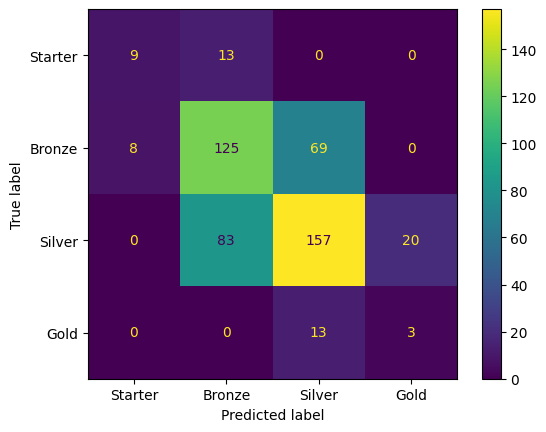

In [295]:
# Confusion matrix
cm = confusion_matrix(y, y_pred, labels=segments)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=segments)
disp.plot()

## Tuning the model

Tune the hyperparameters of the model to improve its performance using [Optuna](https://optuna.org/).

#### Hyperparameters

- `max_depth`: The maximum depth of the tree.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node


In [296]:
from optuna import Trial


def decision_tree_optuna(trial: Trial) -> float:
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_depth = trial.suggest_int("max_depth", 2, 8)

    # Set the hyperparameters for the DecisionTreeClassifier
    model.set_params(
        classifier__min_samples_leaf=min_samples_leaf,
        classifier__max_depth=max_depth,
    )

    # Calculate the accuracy of the model using cross-validation
    scores = cross_val_score(model, X, y, cv=cv_folds, scoring="accuracy")

    # Return the mean accuracy of the model as the objective value
    return scores.mean()

In [297]:
decision_tree_study = optuna.create_study(direction="maximize")
decision_tree_study.optimize(decision_tree_optuna, n_trials=100)

[I 2024-09-03 06:54:14,421] A new study created in memory with name: no-name-6eab6433-8bd9-4dda-ab60-47e33028e889
[I 2024-09-03 06:54:14,441] Trial 0 finished with value: 0.6861097082942549 and parameters: {'min_samples_leaf': 3, 'max_depth': 3}. Best is trial 0 with value: 0.6861097082942549.
[I 2024-09-03 06:54:14,459] Trial 1 finished with value: 0.6880936921338048 and parameters: {'min_samples_leaf': 15, 'max_depth': 4}. Best is trial 1 with value: 0.6880936921338048.
[I 2024-09-03 06:54:14,476] Trial 2 finished with value: 0.6880936921338048 and parameters: {'min_samples_leaf': 15, 'max_depth': 4}. Best is trial 1 with value: 0.6880936921338048.
[I 2024-09-03 06:54:14,494] Trial 3 finished with value: 0.6940215953634898 and parameters: {'min_samples_leaf': 1, 'max_depth': 5}. Best is trial 3 with value: 0.6940215953634898.
[I 2024-09-03 06:54:14,511] Trial 4 finished with value: 0.6740855638121349 and parameters: {'min_samples_leaf': 12, 'max_depth': 6}. Best is trial 3 with value

In [298]:
print(f"Best accuracy: {decision_tree_study.best_value:.5f}")
print(f"Best parameters: {decision_tree_study.best_params}")

Best accuracy: 0.70009
Best parameters: {'min_samples_leaf': 11, 'max_depth': 4}


## Visualize the tree


In [299]:
# Use all data to train the model with the best hyperparameters. This is meant for visualization purposes,
# so overfitting is not a concern here.
X_train_tree = X.copy()
y_train_tree = y.copy()

X_train_tree["localizacao"] = X_train_tree["localizacao"].astype("category").cat.codes
X_train_tree["atividade_economica"] = (
    X_train_tree["atividade_economica"].astype("category").cat.codes
)
X_train_tree.head(10)

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao
0,1,713109.95,12,1,6,1
1,1,790714.38,9,2,15,0
2,1,1197239.33,17,2,4,9
3,2,449185.78,15,2,6,0
4,0,1006373.16,15,2,15,8
5,3,1629562.41,16,1,11,4
6,3,771179.95,13,3,0,1
7,3,707837.61,16,2,10,6
8,1,888983.66,17,0,10,1
9,2,1098512.64,13,1,9,3


In [300]:
decision_tree = DecisionTreeClassifier(
    min_samples_leaf=decision_tree_study.best_params["min_samples_leaf"],
    max_depth=decision_tree_study.best_params["max_depth"],
)

decision_tree.fit(X_train_tree, y_train_tree)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=11)

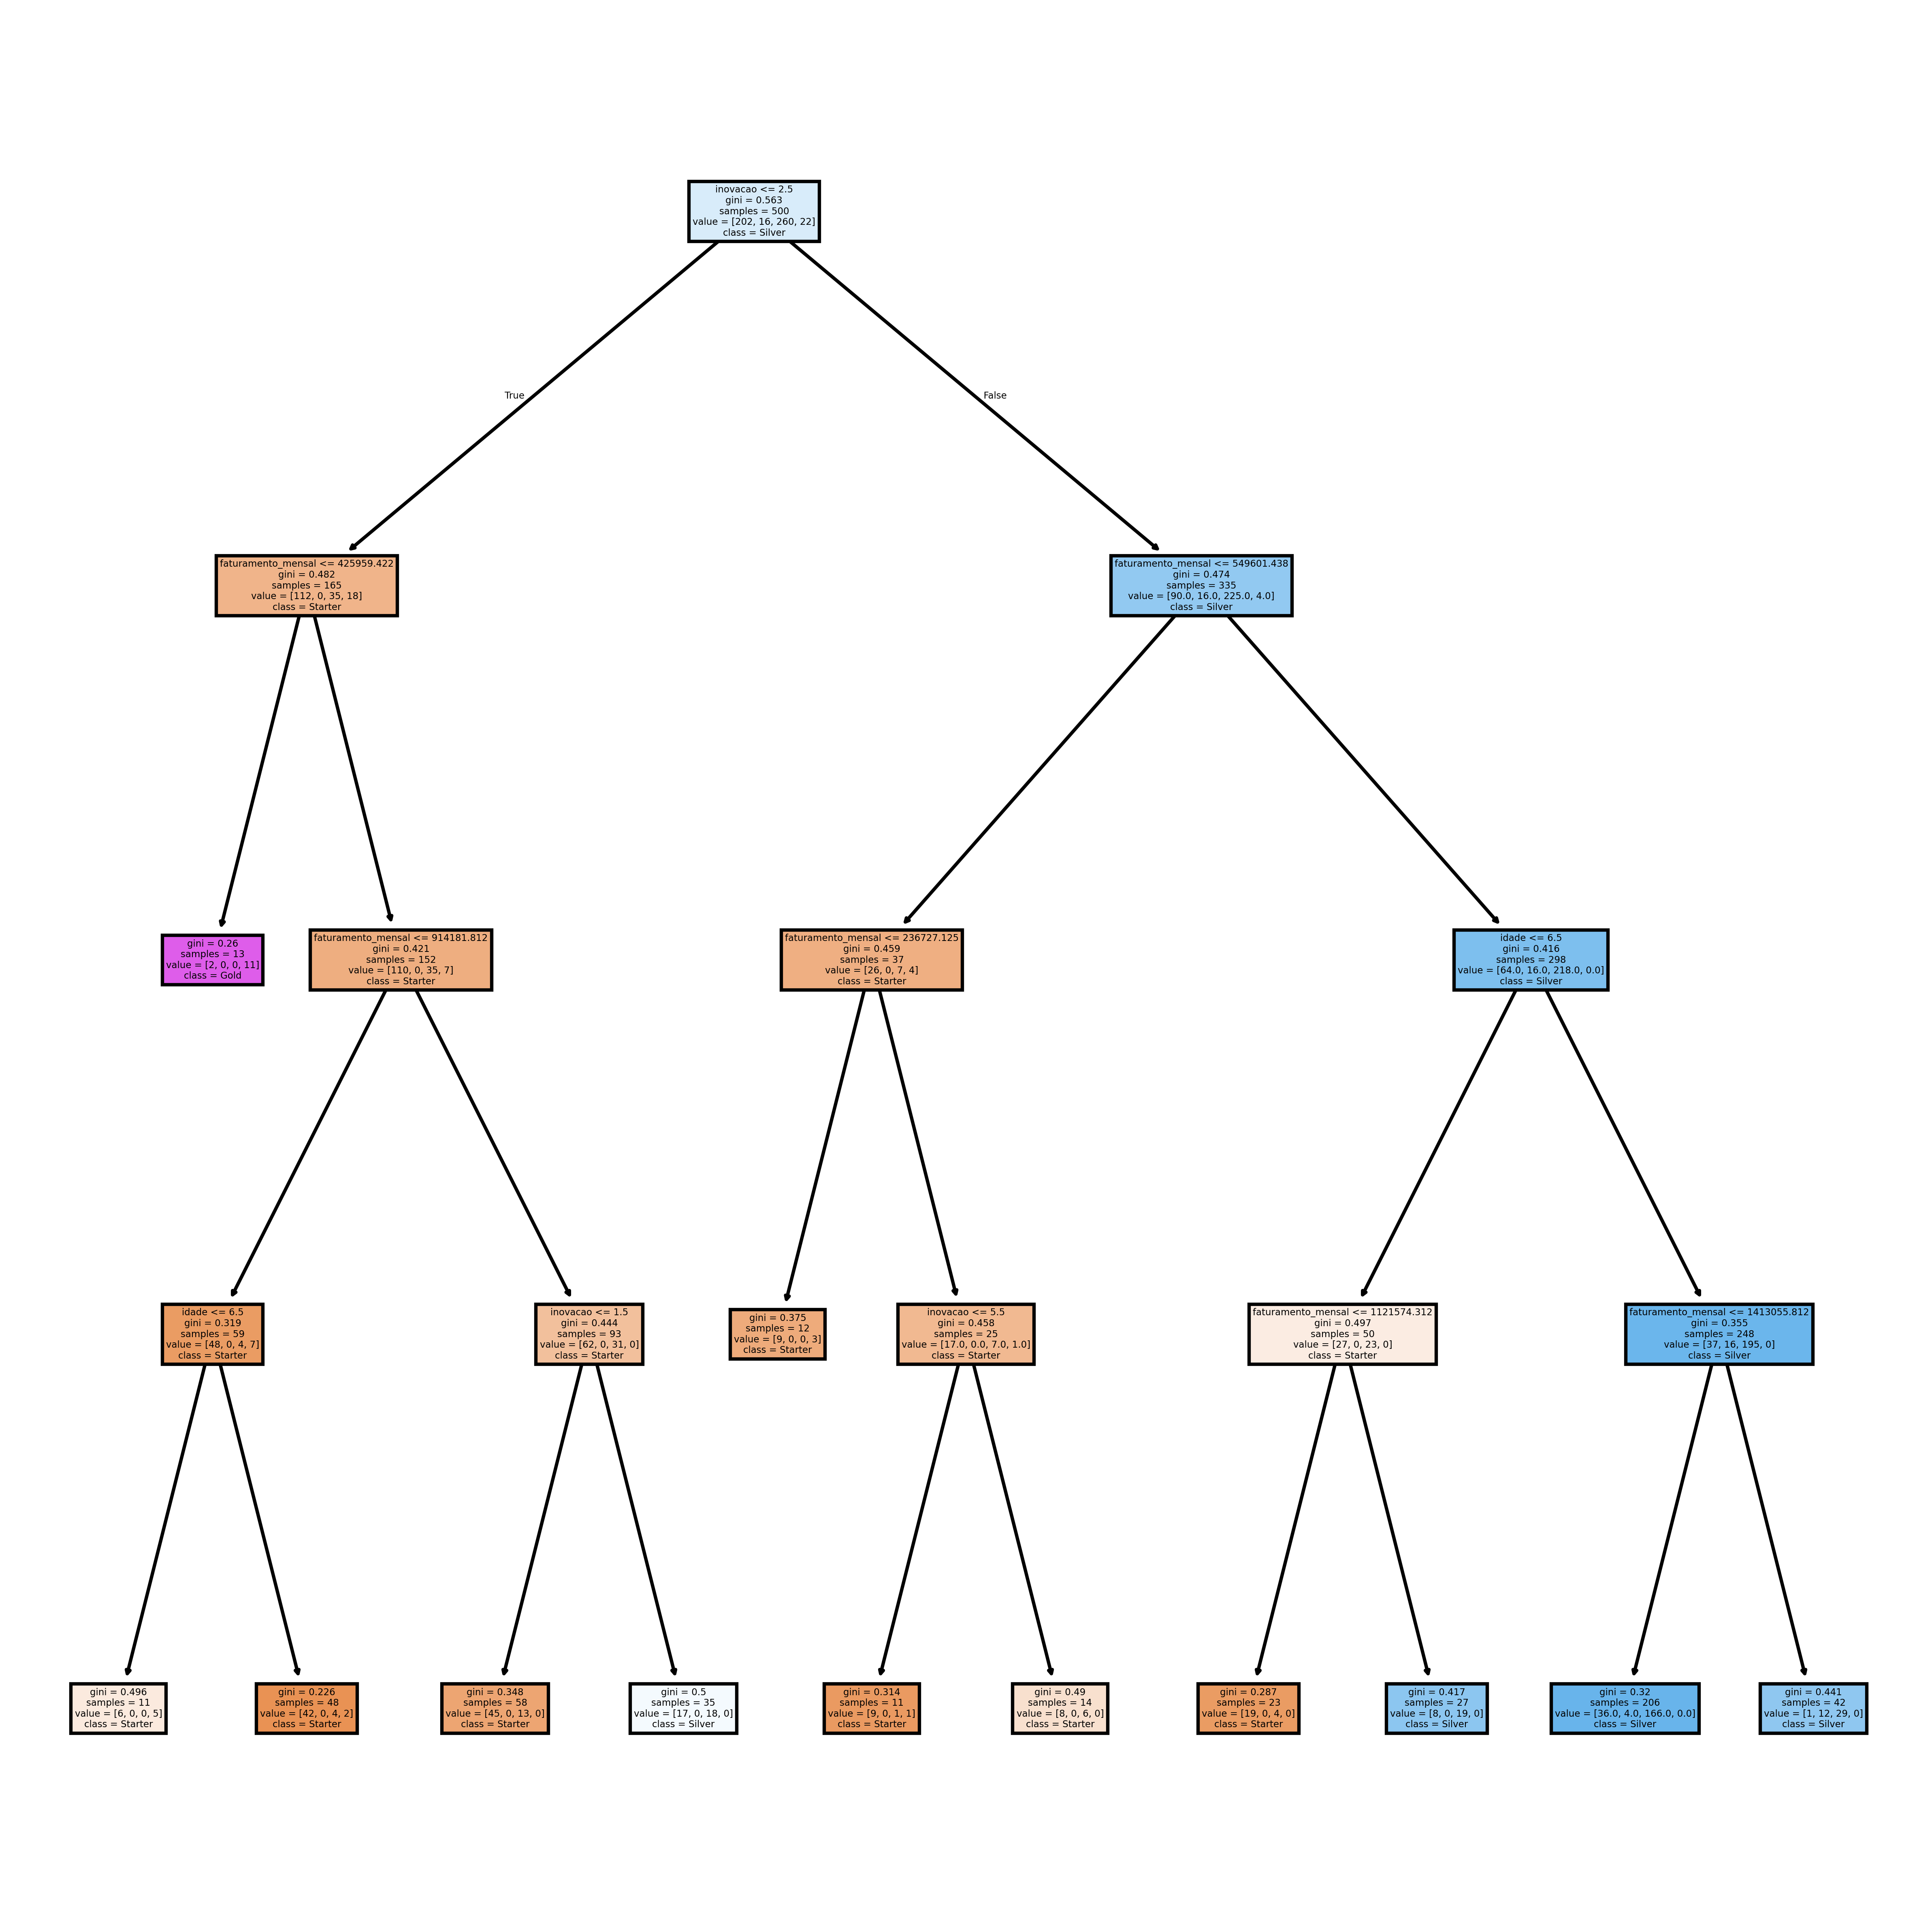

In [301]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), dpi=600)
plot_tree(
    decision_tree,
    feature_names=X.columns,
    class_names=segments,
    filled=True,
)
plt.show()

In [302]:
## Display feature importance
feature_importance = decision_tree.feature_importances_
feature_importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importance}
)

px.bar(
    feature_importance_df,
    x="Feature",
    y="Importance",
    title="Feature Importance",
    labels={"Feature": "Feature", "Importance": "Importance"},
)

## Export the model


In [303]:
import os
import joblib

# Create a pipeline with the best hyperparameters
tuned_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            DecisionTreeClassifier(
                min_samples_leaf=decision_tree_study.best_params["min_samples_leaf"],
                max_depth=decision_tree_study.best_params["max_depth"],
            ),
        ),
    ]
)

# Train the model with all data
tuned_model.fit(X, y)

# Save the model
os.makedirs("models", exist_ok=True)
joblib.dump(tuned_model, "models/customer_segments_model.pkl")

['models/customer_segments_model.pkl']

## Batch application with Gradio


In [305]:
import gradio as gr
from datetime import datetime


model = joblib.load("models/customer_segments_model.pkl")


def predict(file):
    df_companies = pd.read_csv(file.name)
    y_pred = model.predict(df_companies)
    df_segments = pd.DataFrame(y_pred, columns=["segmento_de_cliente"])
    df_predictions = pd.concat([df_companies, df_segments], axis=1)
    df_predictions.to_csv("predictions.csv", index=False)

    return "predictions.csv"


demo = gr.Interface(
    fn=predict,
    inputs=gr.File(file_types=[".csv"]),
    outputs="file",
    title="Customer Segmentation",
    description="Predict the customer segment of companies.",
)

demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
